## Neural Art Demo
This demo is an implementation of the algorithm in the paper [A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576) by Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge.

This algorithm transfers 'artistic style' from one image to the other. For example, you can make your favourite photo looks like van Gogh's painting.

First, we need to images to work with. We extract the 'style' image's style and transfer it to the 'content' image.
The default images are photo of buildings and van Gogh's painting.
You can swap them with any images on the internet you like.

In [1]:
import logging
logging.basicConfig(level=logging.WARN)  # disable the verbose INFO messages for cleaner notebook display

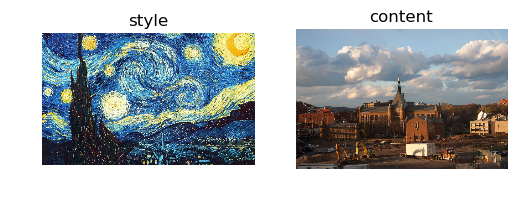

In [2]:
# some setup
%matplotlib inline
import matplotlib.pyplot as plt
import os
import urllib
import numpy as np
from skimage import io

# URL to the style image. Change this to use your own style.
style_url = """https://github.com/dmlc/web-data/raw/master/mxnet/neural-style/input/starry_night.jpg"""
# URL to the content image. Change this to use your own content
content_url = """https://github.com/dmlc/web-data/raw/master/mxnet/neural-style/input/IMG_4343.jpg"""

def ensure_dir(path):
    """Makes sure the path exists so we can save a file to it."""
    dirname = os.path.dirname(path)
    try:
        os.mkdir(dirname)
    except OSError:
        # Probably because the path exists already
        pass

# Download the CNN
cnn_url = "https://github.com/dmlc/web-data/raw/master/mxnet/neural-style/model/vgg19.params"
cnn_path = 'model/vgg19.params'
ensure_dir(cnn_path)
urllib.urlretrieve(cnn_url, cnn_path)

# Download the images
style_path = "input/style.jpg"
content_path = "input/content.jpg"
ensure_dir(style_path)
urllib.urlretrieve(style_url, style_path)
ensure_dir(content_path)
urllib.urlretrieve(content_url, content_path)

style_img = io.imread(style_path)
content_img = io.imread(content_path)

# Show the images
plt.subplot(121)
plt.axis('off')
plt.title('style')
plt.imshow(style_img)
plt.subplot(122)
plt.axis('off')
plt.title('content')
plt.imshow(content_img)

plt.show()

### Set parameters
Now we need to set some parameters. You can tweek these to get a better result.

In [3]:
import nstyle  # Load code for neural style training
args = nstyle.get_args([])  # get the defaults args object

# Stopping criterion. A larger value means less time but lower quality.
# 0.01 to 0.001 is a decent range. 
args.stop_eps = 0.005

# Resize the long edge of the input images to this size.
# Smaller value is faster but the result will have lower resolution.
args.max_size = 600

# content image weight. A larger value means more original content.
args.content_weight = 10.0

# Style image weight. A larger value means more style.
args.style_weight = 1.0

# Initial learning rate. Change this affacts the result.
args.lr = 0.001

# Learning rate schedule.  How often to decrease and by how much
args.lr_sched_delay = 50
args.lr_sched_factor = 0.6

# How often to update the notebook display
args.save_epochs = 50

# How long to run for
args.max_num_epochs = 1000

# Remove noise. The amount of noise to remove.
args.remove_noise = 0.02

args.content_image = content_path
args.style_image = style_path

args.output_dir = 'output/'
ensure_dir(args.output_dir)

### Setup live learning curve chart

In [4]:
import IPython.display
import mxnet.notebook.callback
import math

eps_chart = mxnet.notebook.callback.LiveTimeSeries(y_axis_label='log_10(eps)',
        # Setting y-axis to log-scale makes sense, but bokeh has a bug
        # https://github.com/bokeh/bokeh/issues/5393
        # So I'll calculate log by hand below.
        #y_axis_type='log',  
    )
def show_img(data):
    eps_chart.update_chart_data(math.log10(data['eps']))
    if data.get('filename',None):
        IPython.display.clear_output()
        print("Epoch %d\neps = %g\n" % (data['epoch'], data['eps']))
        h = IPython.display.HTML("<img src='"+data['filename']+"'>")
        IPython.display.display(h)

Loading BokehJS ...

## Start training!
The notebook callback will render the latest saved image during training. 

In [5]:
nstyle.train_nstyle(args, callback=show_img)

Epoch 150
eps = 0.00936081



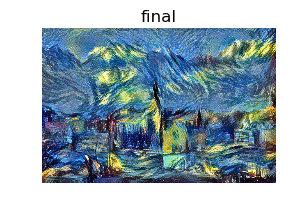

In [7]:
final_img = io.imread(args.output_dir+'final.jpg')

plt.figure(figsize=(3,2))
plt.axis('off')
plt.title('final')
plt.imshow(final_img)
plt.show()